In [1]:
!git clone https://github.com/Project-MONAI/research-contributions.git

Cloning into 'research-contributions'...
remote: Enumerating objects: 2830, done.
remote: Counting objects: 100% (294/294), done.
remote: Compressing objects: 100% (181/181), done.
remote: Total 2830 (delta 152), reused 218 (delta 102), pack-reused 2536 (from 1)
Receiving objects: 100% (2830/2830), 24.82 MiB | 12.88 MiB/s, done.
Resolving deltas: 100% (1602/1602), done.


##Dependencies

In [2]:
!pip install git+https://github.com/Project-MONAI/MONAI.git@07de215c
!pip install nibabel==3.1.1
!pip install tqdm==4.59.0
!pip install tensorboardX==2.1
!pip install monai

##extra dependencies
#!pip uninstall -y nibabel
!pip install nibabel==3.2.1

  Cloning https://github.com/Project-MONAI/MONAI.git (to revision 07de215c) to /tmp/pip-req-build-wpsbbxva
  Running command git clone --filter=blob:none --quiet https://github.com/Project-MONAI/MONAI.git /tmp/pip-req-build-wpsbbxva
  Running command git checkout -q 07de215c
  Resolved https://github.com/Project-MONAI/MONAI.git to commit 07de215c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for monai: filename=monai-0.8.1+271.g07de215c-py3-none-any.whl size=837949 sha256=0e901a6bfdab18a1fd6eaeefb200b19308bf1f0871760d844ab36c2d7f63a7de
  Stored in directory: /tmp/pip-ephem-wheel-cache-0kliybos/wheels/ac/99/be/f56163cfe0e9745f1b5c1ec63737532c7e0e53d366707caca5
Successfully built monai
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 75.0 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 5.0.1
    Uninstalling nibabel-5.0.1:
      Successf

##Setup Enviroment


In [3]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2024-09-02 07:39:32.250885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 07:39:32.582728: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-02 07:39:32.654037: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-02 07:39:33.131393: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-02 07:39:35.425822: W tensorflow/compiler/tf2

Converted DICOM from /content/d1/T1 to NIFTI file /content
Converted DICOM from /content/d1/T1ce to NIFTI file /content
Converted DICOM from /content/d1/T2 to NIFTI file /content
Converted DICOM from /content/d1/flair to NIFTI file /content
Converted DICOM from /content/d2/T1 to NIFTI file /content/Untitled Folder
Converted DICOM from /content/d2/T1ce to NIFTI file /content/Untitled Folder
Converted DICOM from /content/d2/T2 to NIFTI file /content/Untitled Folder
Converted DICOM from /content/d2/flair to NIFTI file /content/Untitled Folder
All conversions are complete.
Using device: cuda


<ipython-input-8-adc68c11f484>:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)["state_dict"])
/usr/local/lib/python3.10/dist-p

Slice with largest tumor volume: 10
Volume for  Class 1 in Mask 1: 9281
Volume for  Class 1 in Mask 2: 1110
Volume difference for class Class 1: -8171

Tumor has shrunk for  Class 1
Volume for  Class 2 in Mask 1: 14316
Volume for  Class 2 in Mask 2: 965
Volume difference for class Class 2: -13351

Tumor has shrunk for  Class 2
Volume for  Class 4 in Mask 1: 2370
Volume for  Class 4 in Mask 2: 177
Volume difference for class Class 4: -2193

Tumor has shrunk for  Class 4


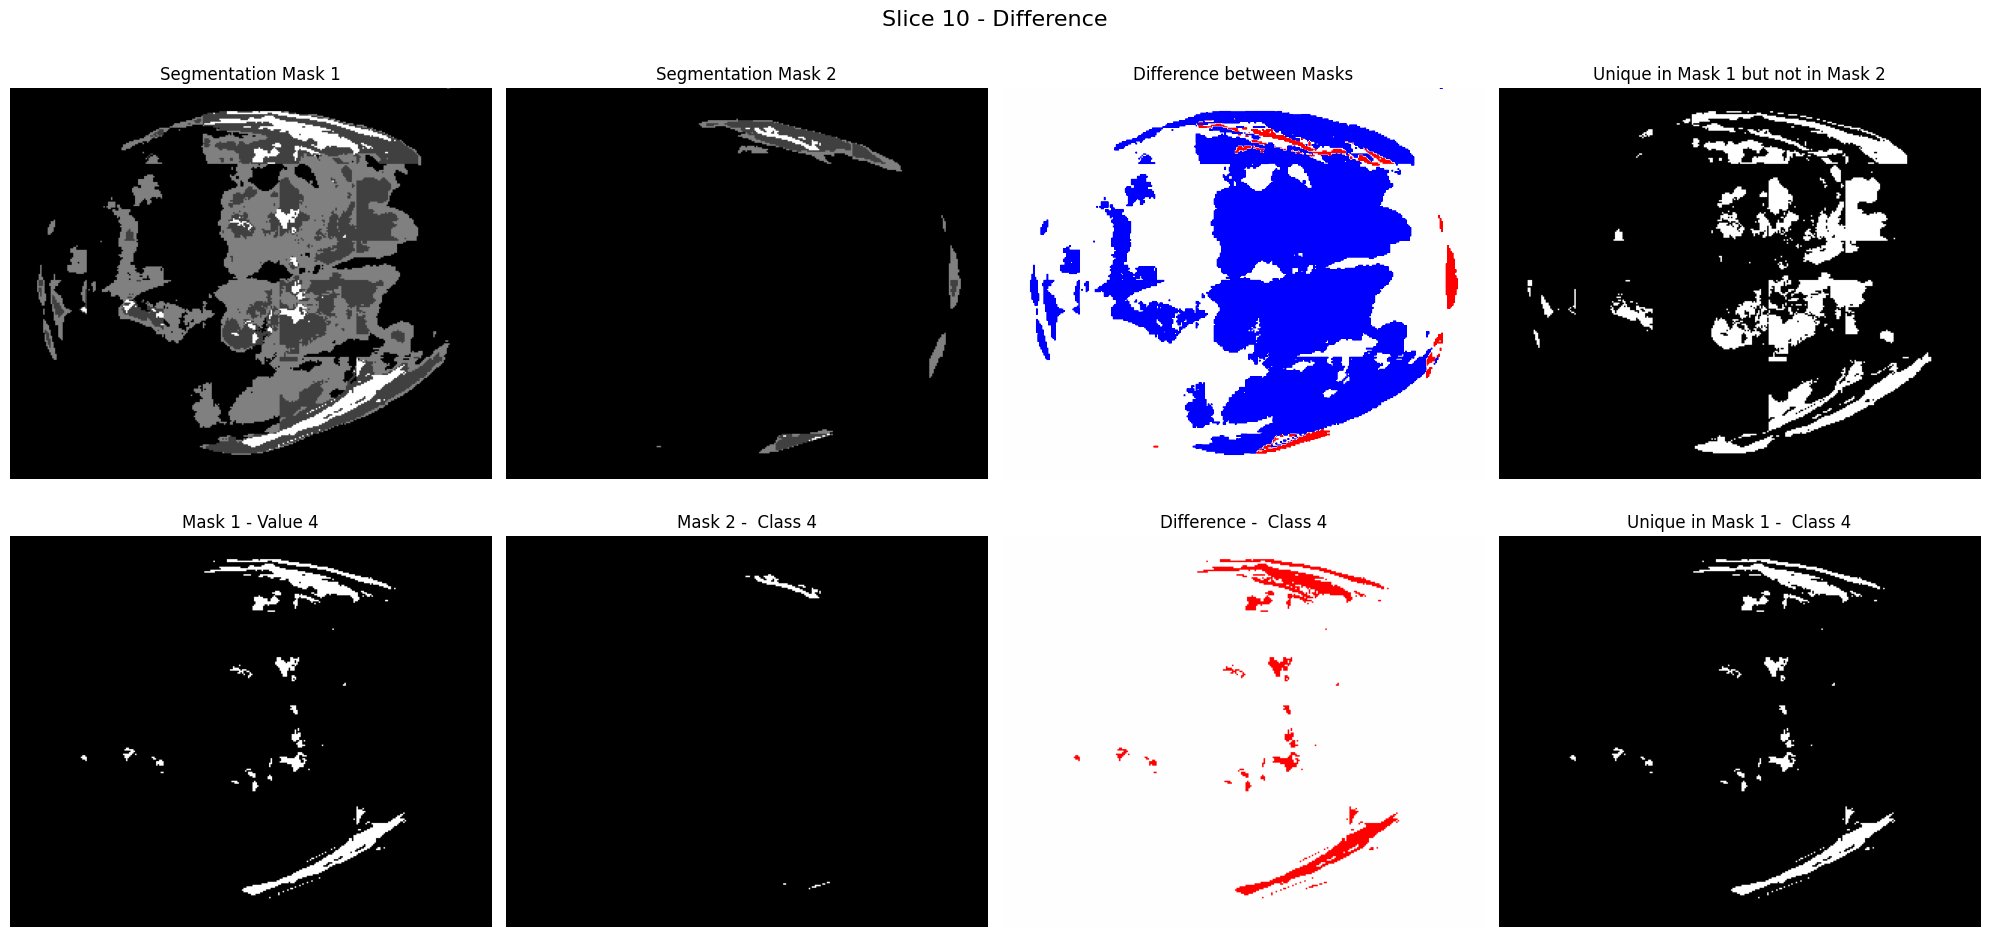

Image saved at ./output_images/comparison_slice_10.png


In [8]:
import os
import pydicom #for conversion
import dicom2nifti# conversion
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torch
from functools import partial
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.data import DataLoader, Dataset
from monai.networks.nets import SwinUNETR

conversion_tasks = [
    {'dicom_directory': '/content/d1/T1', 'output_file': '/content'},
    {'dicom_directory': '/content/d1/T1ce', 'output_file': '/content'},
    {'dicom_directory': '/content/d1/T2', 'output_file': '/content'},
    {'dicom_directory': '/content/d1/flair', 'output_file': '/content'},
    {'dicom_directory': '/content/d2/T1', 'output_file': '/content/Untitled Folder'},
    {'dicom_directory': '/content/d2/T1ce', 'output_file': '/content/Untitled Folder'},
    {'dicom_directory': '/content/d2/T2', 'output_file': '/content/Untitled Folder'},
    {'dicom_directory': '/content/d2/flair', 'output_file': '/content/Untitled Folder'}
]

# Perform the conversions
for task in conversion_tasks:
    dicom_directory = task['dicom_directory']
    output_file = task['output_file']

    # Create the output directory if it does not exist
    output_dir = os.path.dirname(output_file)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Convert DICOM to NIFTI
    dicom2nifti.convert_directory(dicom_directory, output_file)

    print(f"Converted DICOM from {dicom_directory} to NIFTI file {output_file}")

print("All conversions are complete.")

# The NIfTI file will be saved in the specified output directory

# Define the model inference function
def perform_inference(model, data_loader, roi_size, sw_batch_size, overlap):

    model.eval()
    model_inferer = partial(
        sliding_window_inference,
        roi_size=roi_size,
        sw_batch_size=sw_batch_size,
        predictor=model,
        overlap=overlap
    )
    results = []
    with torch.no_grad():
        for batch_data in data_loader:
            image = batch_data["image"].cuda()
            prob = torch.sigmoid(model_inferer(image))
            seg = prob[0].detach().cpu().numpy()
            seg = (seg > 0.5).astype(np.int8)
            seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
            seg_out[seg[1] == 1] = 2
            seg_out[seg[0] == 1] = 1
            seg_out[seg[2] == 1] = 4
            results.append(seg_out)
    return results

# Function to create data loader
def create_data_loader(test_files, roi_size):
    test_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image"]),
            #transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ]
    )
    test_ds = Dataset(data=test_files, transform=test_transform)
    return DataLoader(
        test_ds,
        batch_size=1,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
    )

# Load model
def load_model(model_path, device):
    model = SwinUNETR(
        img_size=(128, 128, 128),
        in_channels=4,
        out_channels=3,
        feature_size=48,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        dropout_path_rate=0.0,
        use_checkpoint=True,
    ).to(device)
    model.load_state_dict(torch.load(model_path)["state_dict"])
    return model

# Function to calculate the volume for a given unique value
def calculate_volume(seg_slice, unique_value):
    return np.sum(seg_slice == unique_value)

# Function to find the slice with the largest tumor volume
def find_largest_volume_slice(seg_out, unique_values):
    max_volume = 0
    best_slice = 0
    for i in range(seg_out.shape[2]):  # Iterate over slices
        current_volume = sum(calculate_volume(seg_out[:, :, i], val) for val in unique_values)
        if current_volume > max_volume:
            max_volume = current_volume
            best_slice = i
    return best_slice

# Inference for two sets of input files
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model_path = "/content/model.pt"
    roi_size = (128, 128, 128)
    sw_batch_size = 1
    overlap = 0.6
    # Define file paths
    input_1 = [
        {
            "image": [
                "/content/Untitled Folder/11_t1post.nii.gz",
                "/content/Untitled Folder/29901_dt1.nii.gz",
                "/content/Untitled Folder/35742_flair_reg.nii.gz",
                "/content/Untitled Folder/11_t1post.nii.gz",
            ],
        }
    ]
    input_2 = [
        {
            "image": [
                "//content/11_t1post.nii.gz",
                "//content/23708_dt1.nii.gz",
                "//content/36500_flair_reg.nii.gz",
                "//content/37906_t2_reg.nii.gz",
            ],
        }
    ]
    model = load_model(model_path, device)
    test_loader_1 = create_data_loader(input_1, roi_size)
    test_loader_2 = create_data_loader(input_2, roi_size)
    # Perform inference
    results_1 = perform_inference(model, test_loader_1, roi_size, sw_batch_size, overlap)
    results_2 = perform_inference(model, test_loader_2, roi_size, sw_batch_size, overlap)
    # Find the slice with the largest tumor volume
    unique_values = [1, 2, 4]  # Unique segmentation values
    classes=['Class 1','Class 1','Class 2','Class 1','Class 4']
    seg_out_1 = results_1[0] if results_1 else np.zeros(roi_size)
    seg_out_2 = results_2[0] if results_2 else np.zeros(roi_size)
    slice_num = find_largest_volume_slice(seg_out_1, unique_values)
    print(f"Slice with largest tumor volume: {slice_num}")
    def visualize_and_save(seg_out_1, seg_out_2, slice_num, unique_values):
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        fig.suptitle(f"Slice {slice_num} - Difference", fontsize=16)
        # Extract slice data
        seg_slice_1 = seg_out_1[:, :, slice_num]
        seg_slice_2 = seg_out_2[:, :, slice_num]
        difference = seg_slice_2 - seg_slice_1
        # Display segmentation mask 1
        axes[0, 0].imshow(seg_slice_1, cmap="gray")
        axes[0, 0].set_title("Segmentation Mask 1")
        axes[0, 0].axis("off")
        # Display segmentation mask 2
        axes[0, 1].imshow(seg_slice_2, cmap="gray")
        axes[0, 1].set_title("Segmentation Mask 2")
        axes[0, 1].axis("off")
        # Display difference between masks
        axes[0, 2].imshow(difference, cmap="bwr", vmin=-1, vmax=1)
        axes[0, 2].set_title("Difference between Masks")
        axes[0, 2].axis("off")
        # Highlight areas where the unique value is present in Mask 1 but not in Mask 2
        highlight = np.logical_and(seg_slice_1 == 1, seg_slice_2 != 1)
        axes[0, 3].imshow(highlight, cmap="gray")
        axes[0, 3].set_title("Unique in Mask 1 but not in Mask 2")
        axes[0, 3].axis("off")
        # Loop through all unique values to generate images
        for i, unique_value in enumerate(unique_values):
            mask_1 = (seg_slice_1 == unique_value)
            mask_2 = (seg_slice_2 == unique_value)
            diff_mask = np.logical_xor(mask_2, mask_1)
            # Display the mask for the specific value in Mask 1
            axes[1, 0].imshow(mask_1, cmap="gray")
            axes[1, 0].set_title(f"Mask 1 - Value {unique_value}")
            axes[1, 0].axis("off")
            # Display the mask for the specific value in Mask 2
            axes[1, 1].imshow(mask_2, cmap="gray")
            axes[1, 1].set_title(f"Mask 2 -  {classes[unique_value]}")
            axes[1, 1].axis("off")
            # Display difference for the specific value between masks
            axes[1, 2].imshow(diff_mask, cmap="bwr", vmin=-1, vmax=1)
            axes[1, 2].set_title(f"Difference -  {classes[unique_value]}")
            axes[1, 2].axis("off")
            # Highlight where the unique value is present in Mask 1 but not in Mask 2
            highlight_unique = np.logical_and(mask_1, np.logical_not(mask_2))
            axes[1, 3].imshow(highlight_unique, cmap="gray")
            axes[1, 3].set_title(f"Unique in Mask 1 -  {classes[unique_value]}")
            axes[1, 3].axis("off")
            # Calculate and print volumes
            volume_1 = calculate_volume(seg_out_1[:, :, slice_num], unique_value)
            volume_2 = calculate_volume(seg_out_2[:, :, slice_num], unique_value)
            volume_difference = volume_2 - volume_1
            print(f"Volume for  {classes[unique_value]} in Mask 1: {volume_1}")
            print(f"Volume for  {classes[unique_value]} in Mask 2: {volume_2}")
            print(f"Volume difference for class {classes[unique_value]}: {volume_difference}\n")
            # Check if the tumor has grown or shrunk
            if volume_difference > 0:
                print(f"Tumor has grown for  {classes[unique_value]}")
            elif volume_difference < 0:
                print(f"Tumor has shrunk for  {classes[unique_value]}")
            else:
                print(f"No change in tumor volume for  {classes[unique_value]}")
        # Save images
        output_directory = "./output_images"
        os.makedirs(output_directory, exist_ok=True)
        image_path = os.path.join(output_directory, f"comparison_slice_{slice_num}.png")
        plt.tight_layout()
        plt.savefig(image_path, bbox_inches="tight")
        plt.show()
        plt.close()
        print(f"Image saved at {image_path}")

    # Visualize and save images
    visualize_and_save(seg_out_1, seg_out_2, slice_num, unique_values)



if __name__ == "__main__":
    main()

